# Product Recommendation Systems 


Context - Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

In [3]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from  sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy.sparse.linalg import svds
import time

In [4]:
# Importing the dataset
dataset = pd.read_csv('ratings_Electronics.csv',names=["userId", "productId", "rating", "timestamp"])

In [5]:
dataset.shape

(7824482, 4)

In [6]:
dataset.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

- **Since we removed Timestamp from the data frame df1, we have only 3 columns. Datatypes of UserId, ProductId and Ratings are object, object and float respectively**



In [7]:
 dataset['userId'].nunique()

4201696

In [8]:
dataset['productId'].nunique()

476002

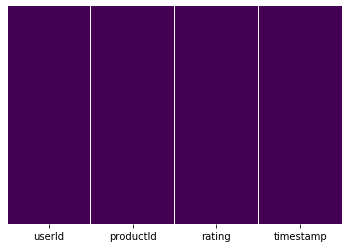

In [9]:
sns.heatmap(dataset.isna(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
dataset.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

- **There is no missing or Nan values present in this dataset**

In [11]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


- **5 point summary looks reasonable.**
- **Minimum rating present in the dataset is 1.**
- **Maximum rating present in the dataset is 5.**
- **Average rating present in the dataset is 4.**
- **Mean of rating is less than median. So, the distribution is left skewed.**

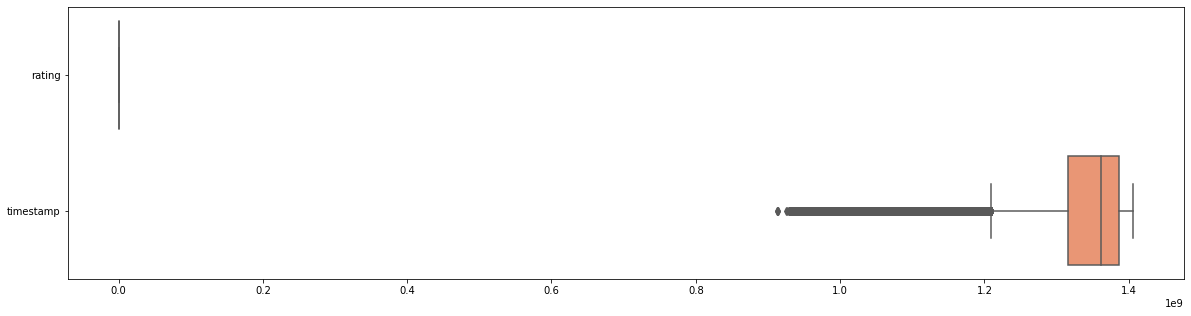

In [12]:
plt.figure(figsize=(20,5))
sns.boxplot(data=dataset, orient='h', palette='Set2', dodge=False)

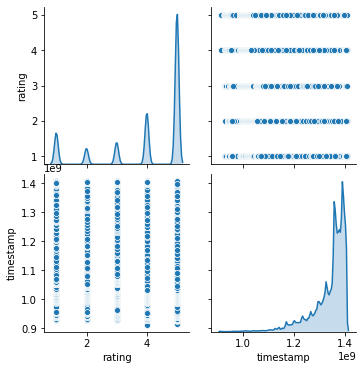

In [13]:
sns.pairplot(dataset, diag_kind= 'kde')

In [14]:
dataset['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

In [15]:
rating_counts = pd.DataFrame(dataset['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5.0,4347541
1,4.0,1485781
2,1.0,901765
3,3.0,633073
4,2.0,456322


Text(0, 0.5, 'Count')

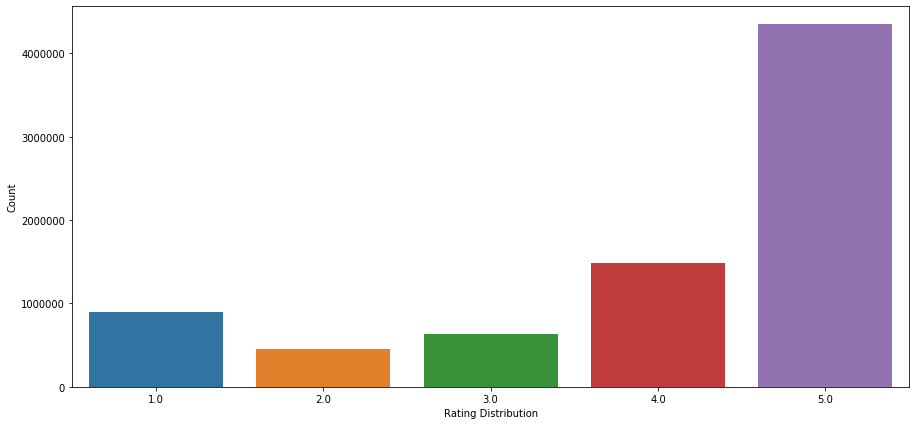

In [16]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
sns.countplot(dataset['rating'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)

- **From the barplot, we can conclude more products are liked by the customers.**

In [17]:
dataset.corr()

,rating,timestamp
rating,1.000000,0.041648
timestamp,0.041648,1.000000


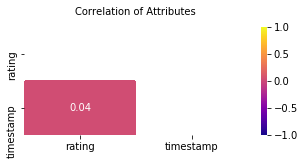

In [18]:
mask = np.zeros_like(dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,2))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(dataset.corr(),vmin=-1, cmap='plasma',annot=True,  mask=mask, fmt='.2f')

In [19]:
dataset = dataset.drop(['timestamp'], axis=1)

In [20]:
df = dataset.copy()

In [21]:
df.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [22]:
users_counts = df['userId'].value_counts().rename('users_counts')
users_data   = df.merge(users_counts.to_frame(),
                                left_on='userId',
                                right_index=True)

# Create Subset of Dataset to make it less sparse/ denser

In [23]:
subset_df = users_data[users_data.users_counts >= 50]
subset_df.head()

,userId,productId,rating,users_counts
94,A3BY5KCNQZXV5U,0594451647,5.0,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


In [24]:
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='productId',
                                right_index=True)

In [25]:
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,rating,users_counts,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,65,18


# Popularity Based Recommendation
# 1. Popularity Recommender model - Using mean of product rating - Top 5

In [26]:
amazon_df = product_rating_data.copy()

In [27]:
panda_data = amazon_df.drop(['users_counts', 'product_rating_counts'], axis=1)

In [28]:
panda_data.head()

,userId,productId,rating
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0


In [29]:
reader = Reader(rating_scale=(1, 5))

In [30]:
surprise_data = Dataset.load_from_df(panda_data[['userId', 'productId', 'rating']], reader)

# Split the data randomly into a train and test dataset

In [31]:
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

In [32]:
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [33]:
panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00006HSML    5.0
B001TH7GUA    5.0
B000IJY8DS    5.0
B005LDLP8W    5.0
Name: rating, dtype: float64

In [34]:
#initializing top 5 ratings
k=5
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())
prod_rating_count.head(k)

,rating,prod_rating_count
productId,,
B00L3YHF6O,5.0,14
B00006HSML,5.0,10
B001TH7GUA,5.0,17
B000IJY8DS,5.0,17
B005LDLP8W,5.0,16


In [35]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

,rating,prod_rating_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [36]:
#Count of user_id for each unique song as recommendation score 
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped.head()

,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [37]:
#Sort the songs on recommendation score 
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = panda_data_sort.head(k) 
popularity_recommendations 

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0


Text(0, 0.5, 'Number of Purchases')

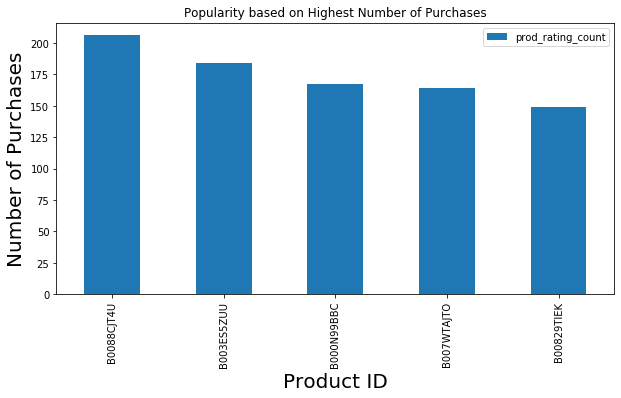

In [42]:
basic_poplurity_model#.drop('rating', axis=1, inplace=True)
ax2 = basic_poplurity_model.head(5).plot(kind='bar',figsize = (10,5),
                                 title="Popularity based on Highest Number of Purchases",fontsize=10)
ax2.set_xlabel("Product ID", fontsize=20)
ax2.set_ylabel("Number of Purchases", fontsize=20)

In [43]:
# UsINNG popularity based recommender model to make predictions
import warnings
warnings.filterwarnings('ignore')
def recommend(userId):     
    user_recommendations = popularity_recommendations 
          
    #Adding user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = userId 
      
    #Bringing user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [44]:
find_recom = [15,121,55,230,344]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

      userID   productId  score  Rank
1592      15  B0088CJT4U    206   1.0
839       15  B003ES5ZUU    184   2.0
226       15  B000N99BBC    167   3.0
1552      15  B007WTAJTO    164   4.0
1577      15  B00829TIEK    149   5.0


Here is the recommendation for the userId: 121

      userID   productId  score  Rank
1592     121  B0088CJT4U    206   1.0
839      121  B003ES5ZUU    184   2.0
226      121  B000N99BBC    167   3.0
1552     121  B007WTAJTO    164   4.0
1577     121  B00829TIEK    149   5.0


Here is the recommendation for the userId: 55

      userID   productId  score  Rank
1592      55  B0088CJT4U    206   1.0
839       55  B003ES5ZUU    184   2.0
226       55  B000N99BBC    167   3.0
1552      55  B007WTAJTO    164   4.0
1577      55  B00829TIEK    149   5.0


Here is the recommendation for the userId: 230

      userID   productId  score  Rank
1592     230  B0088CJT4U    206   1.0
839      230  B003ES5ZUU    184   2.0
226   

# Collaborative Filtering model
#  I am going to use SVD,SVDpp and KNNWithMeans for the Collaborative Filtering Model.
# Grid Search to find out the best hyper parameters for SVD and SVDpp Algorithm.

In [45]:
cv_results = []  # to store cross validation result 

In [46]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=2)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=2)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

0.8868919604322738
0.8882597565463125
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [47]:
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=10, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.9099  0.8960  0.9030  0.0069  
MAE (testset)     0.6845  0.6806  0.6826  0.0019  
Fit time          2.64    2.70    2.67    0.03    
Test time         0.70    0.56    0.63    0.07    


==================== Model Evaluation ===============================
RMSE: 0.8915

 Computational Time : 11.547s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.902953,0.682582,2.671884,0.632846


In [48]:
start_time = time.time()

# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=10, lr_all=0.01, reg_all=0.4)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)


# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'], 
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVDpp on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.8916  0.8873  0.8894  0.0021  
MAE (testset)     0.6646  0.6683  0.6664  0.0018  
Fit time          16.59   16.52   16.55   0.04    
Test time         2.80    2.94    2.87    0.07    


==================== Model Evaluation ===============================
RMSE: 0.8806

 Computational Time : 73.572s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.902953,0.682582,2.671884,0.632846
1,SVDpp,0.889435,0.666432,16.554917,2.867239


- **grid search to find out the best hyper parameters for KNNBasic, KNNWithMeans and KNNWithZScore Algorithm.**

In [49]:
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=2)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=2)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=2, n_jobs=2)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

1.024634467911199
0.9781233211647384
0.9923741878593835
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}

Computational Time : 1592.074s


# User Collaborative filtering by KNNBasic
It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. It is a personalized recommendation.

In [50]:

# Creating Model using best parameters
knnBasic_model = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], 
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.0603  1.0533  1.0568  0.0035  
MAE (testset)     0.7385  0.7367  0.7376  0.0009  
Fit time          1.80    1.69    1.75    0.05    
Test time         2.67    2.81    2.74    0.07    


==================== Model Evaluation ===============================
RMSE: 1.0070

 Computational Time : 1608.362s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.902953,0.682582,2.671884,0.632846
1,SVDpp,0.889435,0.666432,16.554917,2.867239
2,KNNBasic,1.056782,0.737624,1.745002,2.737748


# User Collaborative filtering by KNNWithZscore
It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. It is a personalized recommendation.

In [51]:

# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], 
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.9899  0.9919  0.9909  0.0010  
MAE (testset)     0.6860  0.6874  0.6867  0.0007  
Fit time          2.02    1.96    1.99    0.03    
Test time         2.76    2.97    2.87    0.11    


==================== Model Evaluation ===============================
RMSE: 0.9541

 Computational Time : 1624.913s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.902953,0.682582,2.671884,0.632846
1,SVDpp,0.889435,0.666432,16.554917,2.867239
2,KNNBasic,1.056782,0.737624,1.745002,2.737748
3,KNNWithZScore,0.990892,0.686711,1.986299,2.867912


# User Collaborative filtering by KNNWithMeans
It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. It is a personalized recommendation.

In [52]:

# Creating Model using best parameters
knnMeansUU_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(trainset)

# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], 
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansUU, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9205  0.8938  0.9126  0.9243  0.9139  0.9130  0.0105  
MAE (testset)     0.6476  0.6304  0.6420  0.6442  0.6430  0.6414  0.0058  
Fit time          2.12    1.87    1.88    2.28    2.13    2.06    0.16    
Test time         1.45    1.46    1.42    1.82    1.54    1.54    0.15    


==================== Model Evaluation ===============================
RMSE: 0.9364

 Computational Time 

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.902953,0.682582,2.671884,0.632846
1,SVDpp,0.889435,0.666432,16.554917,2.867239
2,KNNBasic,1.056782,0.737624,1.745002,2.737748
3,KNNWithZScore,0.990892,0.686711,1.986299,2.867912
4,KNNWithMeans User-User,0.912998,0.641433,2.055012,1.539147


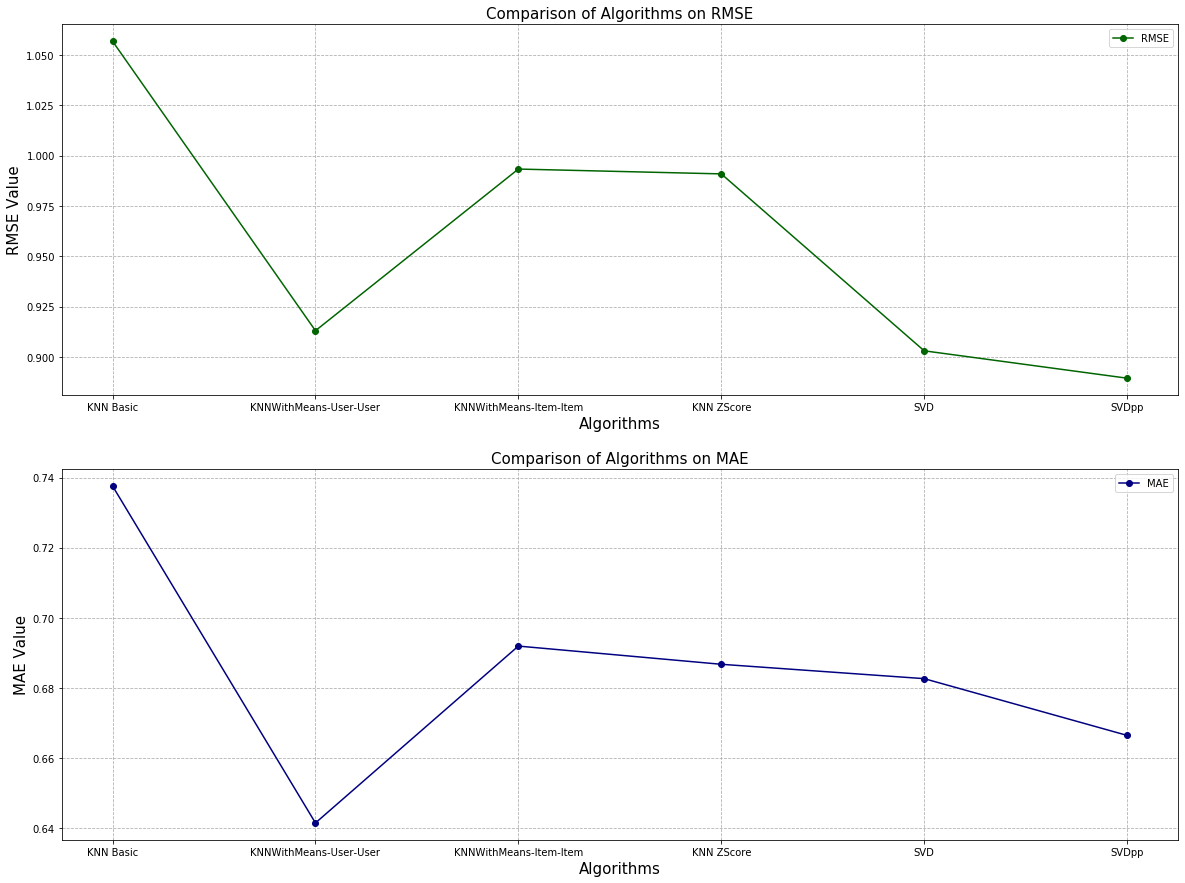

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.902953,0.682582,2.671884,0.632846
1,SVDpp,0.889435,0.666432,16.554917,2.867239
2,KNNBasic,1.056782,0.737624,1.745002,2.737748
3,KNNWithZScore,0.990892,0.686711,1.986299,2.867912
4,KNNWithMeans User-User,0.912998,0.641433,2.055012,1.539147
5,KNNWithMeans Item-Item,0.993335,0.691871,1.807842,2.875389


In [54]:
x_algo = ['KNN Basic', 'KNNWithMeans-User-User', 'KNNWithMeans-Item-Item', 'KNN ZScore', 'SVD', 'SVDpp']
all_algos_cv = [knnBasic_cv, knnMeansUU_cv, knnMeansII_cv, knnZscore_cv, svd_cv, svdpp_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,15))

plt.subplot(2, 1, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(2, 1, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

cv_results

Evaluation Results :
From above algorithm comparisons plots we can infer the followings:

- **RMSE : we can see that SVD++ is giving the best RMSE value with parameters {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.4} and SVD is giving the second best RMSE with parameters {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}**
- **MAE : Here SVD++ and KNNWithMeans both are giving the best MAE value.**
- **Svd++ is having the best RMSE in Matrix Factorization Based Algorithms.**
- **KNNWithMeans is giving the best RMSE in Collaborative Filtering Algorithms.**
- **Important : If compare SVD and SVD++ then can notice that RMSE and MAE value of SVD is slightly differs from the SVD++ but the Fit Time and Test Time taken by SVD is significant less(12 times) than SVD++. So, we will proceed with SVD got get top-k recommendations**
- **top - K ( K = 5) recommendations**
- **Here I am using SVD algorithm to get the top 5 recommendations of new products for each user.**

In [56]:
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list,
            {'AZBXKUH4AIW3X': [('B00316263Y', 4.595122211794261),
              ('B005LDLP8W', 4.5682807851202645),
              ('B008EQZ25K', 4.541441197318157),
              ('B000BSN4UY', 4.540359231017005),
              ('B005DKZTMG', 4.500878806880677)],
             'A1T1YSCDW0PD25': [('B0099SMFVQ', 4.823145357924229),
              ('B004S4R5CK', 4.805457761481801),
              ('B0002SQ2P2', 4.760379850769213),
              ('B000CKVOOY', 4.728185962500174),
              ('B000AZ57M6', 4.705915705830083)],
             'A1HYH206E18XVC': [('B006EKIQYM', 4.499153698142966),
              ('B003YKG2UK', 4.249749444542989),
              ('B00CE590Z0', 4.2293558692996625),
              ('B002VPE1XY', 4.158257015062116),
              ('B005DM9BGE', 4.0906811547102615)],
             'A2ZFFSJ0VM6KSJ': [('B005DOK8NW', 4.715196884518258),
              ('B007I5JT4S', 4.617410819400133),
              ('B00AAIPT76', 4.593510993599168),
              ('B008AST

Comment : From the above list we can see that model is recommending top 5 products to each user. There are some cases which it recommends less than 5 products. It happend because model is not able to find appropriate number of neighbours.

=> Precision and recall at k=5

In [57]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


kf = KFold(n_splits=5)
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
precs = []
recalls = []

for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print('Precision : ', sum(prec for prec in precisions.values()) / len(precisions))
    print('recalls : ',sum(rec for rec in recalls.values()) / len(recalls))

Precision :  0.8635853379152326
recalls :  0.8292699095458245
Precision :  0.8682648401826469
recalls :  0.83643531234778
Precision :  0.8732340720221594
recalls :  0.8269824502048027
Precision :  0.8783195970695947
recalls :  0.8305668841275172
Precision :  0.8860882487425679
recalls :  0.8336375713751155


# Conclusion

- **I have calculated Precision and recall at k=5.**

- **My precision at 5 in a top-5 recommendation problem is alomost 87%. This means that 87% of the recommendation are relevent to the users.**

- **My recall at 5 in a top-5 recommendation problem is almost 83%. This means that 83% of the total number of the relevent products appear in the top-k result.**

- **I have used 'Matrix Factorization Based Algorithms' & 'k-NN Based Algorithms' to build Collaborative Filtering model.**

- **We have also seen that KNNWithMeans is performing well compare to other k-NN Based Algorithms.**

- **SVD with parameters => Number of Epochs = 10, Learning Rate= 0.005, Regularization Term = 0.2**

- **I have computed the precision which is almost 87%. Here we can interpret that 87% of my recommendations are actually relevant to the user.**
- **In recall we can interpret that 83% percent of the relevant items were recommended in the top-k items.**

### SVDS for Top 5 model

- **As SVD based algoritym  has come out well based on recall and precision displaying its traits, so applying SVDS for more clear representation of TOP model using Collaborative Filtering model**

In [66]:
# Function to return recommendation for specific user
def recommendations(predictions, usr):
    for uid, iid, true_r, est, _ in predictions_svd:
        if uid == usr:
            aiid.append(iid)
            aest.append(est)
         
    return aiid, aest

In [73]:
final= panda_data.copy()

In [80]:
aiid = []
aest = []

usr = 'AZBXKUH4AIW3X' # UserId for which recommendation is going to be returned
recommendations(predictions_svd,usr)

df_res2 = pd.DataFrame(aiid, columns=['productId'])
df_res2['rating'] = aest
df_res2.sort_values(by='rating',ascending=False,inplace=True)
df_res2.drop("rating", axis=1,inplace=True)  
df_res2.set_index('productId',inplace=True)  
print("Recommendation for UserId : ", usr)
df_res2[0:5]

Recommendation for UserId :  AZBXKUH4AIW3X


""
productId
B00316263Y
B005LDLP8W
B008EQZ25K
B000BSN4UY
B005DKZTMG


In [90]:
pivot_final = final.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
final_ratings_matrix= pivot_final.copy()
pivot_final_t1['User_Index'] = np.arange(0, pivot_final.shape[0],1)
pivot_final_t1 = pivot_final_t1['User_Index']

In [91]:
cl2 = [5,7,9,11,12,14]
svd_a = []
svd_rmse = []
for a in cl2: 
    rmse_df = pd.DataFrame()
    U, sigma, Vt = svds(pivot_final, k = a) # SVD built for each k value from the array  
    sigma = np.diag(sigma) # creates sigma diagonal matrix 
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # A = U.simga.Vt -> predict the ratings 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_final.columns) #loads the predicted ratings in a df
    rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1) 
    svd_rmse.append((mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings))**0.5)
    svd_a.append(a)

In [92]:
# Singular Value Decomposition with k value 12
U, sigma, Vt = svds(pivot_final, k = 12) 
sigma = np.diag(sigma) 

In [93]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # A = U.simga.Vt -> predicts the ratings for k value 12
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_final.columns) # predicted ratings are stored in preds_df
preds_df.head()

productId,B00001P4XA,B00001P4ZH,B00001WRSJ,B00001ZWXA,B00004SABB,B00004SB92,B00004T8R2,B00004THCZ,B00004WCIC,B00004WCID,...,B00JXVPHC8,B00JY4QCJQ,B00K91DB7Y,B00KJJW36G,B00KNM763E,B00KVNY2KA,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O
0,0.043149,0.078139,0.044463,0.033077,0.098521,-0.011799,0.065455,-0.015704,-0.052523,-0.003352,...,0.265407,-0.014332,0.046014,0.048296,0.014644,0.314858,0.403016,0.310665,0.319495,0.406427
1,0.027867,0.051489,0.015915,0.091954,0.006625,0.171009,0.091181,0.062546,0.154655,0.003303,...,0.124874,0.121224,0.159481,0.075279,0.155044,0.109422,0.138529,0.071407,0.074714,0.087377
2,0.041580,0.036362,0.026303,-0.006515,-0.036378,0.097358,0.007924,0.017740,0.028824,0.004006,...,-0.039772,0.089869,0.206971,0.192504,0.091659,-0.035260,-0.026517,-0.035258,0.011092,-0.009169
3,0.038048,0.050993,0.044002,0.033098,0.034595,0.022502,0.045920,0.019452,0.026325,0.018401,...,0.028978,-0.008320,0.025597,-0.005976,-0.009105,-0.026187,-0.048740,-0.034005,-0.034826,0.060241
4,0.023141,0.033506,0.027310,0.063946,0.032866,0.094035,0.034389,0.003335,0.024065,0.001714,...,0.037686,0.040455,0.079136,0.046684,0.066784,-0.050195,-0.001362,-0.058007,-0.021324,0.039348


In [95]:

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False) #user_idx is the row number
    # Sort the predicted user ratings 
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1) #merge actual and predicted ratings
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   # filtering users who have given no ratings
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the Recommended Items for {} \n'.format(pivot_final_t1[userID:userID+1]))
    print(temp.head(num_recommendations)) 

In [96]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 14
num_recommendations = 5
recommend_items(userID, pivot_final, preds_df, num_recommendations)


Below are the Recommended Items for [14] 

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.372073
B002V88HFE                  0.0          0.347705
B000JMJWV2                  0.0          0.274401
B000LRMS66                  0.0          0.261371
B000QUUFRW                  0.0          0.248924



Above 5 products are recommended for user A110VKXAVLAYKY. The model provides 5 recommended items for input user id.

In [98]:
svd_rmse_f = sqrt(mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings))
print('\nRMSE of SVD Model = {} \n'.format(svd_rmse_f))

svd_mae_f = mean_absolute_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings)
print('\nMAE of SVD Model  = {} \n'.format(svd_mae_f))


RMSE of SVD Model = 0.008648954194828525 


MAE of SVD Model  = 0.006632885711778052 



# Conclusion:

● Exploratory Data Analysis : I Have done EDA to understand the data in precise way and found that most of the      customers have given 5 rating. Which gives us an important information that Amazon is performing good in terms of Electronics Products sell.Did thorough EDA on data and removed few of the unwanted data and variables   

● Data Wrangling : worked on sparse and dense data to make it lesser. And dealt to deal with bulk data and                 lessen the data with rating >= 50 was considered. 

● Build a Popularity recommender model: Built popularity based model and predicted top 5 products.   

● Build Collaborative Filtering mode: based on Precision and recall value with respective to RSME,MAE SVD and              KNNwithMeans gave best results. Wile SVD stood out at end with good RSME and MAE values.